In [ ]:
import sys
import os

# Ruta al proyecto raíz donde está la carpeta 'scripts'
project_root = os.path.abspath('../../../')  # o usa la ruta absoluta si prefieres
sys.path.append(project_root)

In [2]:
import pandas as pd 
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from scripts.remove_outliers import remove_outliers
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
import joblib

In [3]:
df_data_general = pd.read_csv('../../../data/data_general.csv')

df_data_general['INITIAL_TIME'] = pd.to_datetime(df_data_general['INITIAL_TIME'])
df_data_general['FINAL_TIME'] = pd.to_datetime(df_data_general['FINAL_TIME'])

df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_period('D')
df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_timestamp()


df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_period('D')
df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_timestamp()

df_data_general['Weekday']= df_data_general['INITIAL_TIME'].dt.strftime('%A')
df_data_general['number_of_day'] = df_data_general['INITIAL_TIME'].dt.day_of_week

df_data_general['TIME_ON_DEVICE_MIN'] = df_data_general['TIME_ON_DEVICE_SEC'] / 60

df_data_general['Hour'] = df_data_general['INITIAL_TIME'].dt.hour
df_data_general['Weekday'] = df_data_general['INITIAL_TIME'].dt.weekday   # 0=Lunes, 6=Domingo
df_data_general['Weekend'] = (df_data_general['Weekday'] >= 5).astype(int)
df_data_general['Month'] = df_data_general['INITIAL_TIME'].dt.month

df_data_general = df_data_general[df_data_general['TIME_ON_DEVICE_MIN'] < 600 ]

df_data_general = df_data_general[df_data_general['WIN_TOTAL'] > 0]
df_data_general['NET_SPEND'] = df_data_general['FINAL_AMOUNT'] - df_data_general['INITIAL_AMOUNT']
df_data_general = df_data_general[df_data_general['NET_SPEND'] < 10000 ]

In [4]:
tiempo_modelo = keras.models.load_model(
                        '../../../models/tiempo_model.h5',
                        custom_objects={
                            'mse': tf.keras.metrics.MeanSquaredError(),
                            'mae': tf.keras.metrics.MeanAbsoluteError(),
                            'mean_squared_error': tf.keras.metrics.MeanSquaredError(),
                            'mean_absolute_error': tf.keras.metrics.MeanAbsoluteError()
                        },
                        compile=False  # No compilar el modelo al cargar
                    )
                    # Recompilar el modelo con métricas actualizadas
tiempo_modelo.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

tiempo_scaler = joblib.load('../../../models/tiempo_scaler.pkl')

2025-10-09 09:23:59.822960: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
bet_model = keras.models.load_model(
                        '../../../models/bet_model.h5',
                        custom_objects={
                            'mse': tf.keras.metrics.MeanSquaredError(),
                            'mae': tf.keras.metrics.MeanAbsoluteError(),
                            'mean_squared_error': tf.keras.metrics.MeanSquaredError(),
                            'mean_absolute_error': tf.keras.metrics.MeanAbsoluteError()
                        },
                        compile=False  # No compilar el modelo al cargar
                    )
                    # Recompilar el modelo con métricas actualizadas
bet_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

bet_scaler = joblib.load('../../../models/bet_scaler.pkl')

In [6]:
print(bet_scaler.feature_names_in_)

['INITIAL_AMOUNT' 'AVG_BET' 'Cluster' 'tiempo_pred']


In [7]:
print(tiempo_scaler.feature_names_in_)


['INITIAL_AMOUNT' 'AVG_BET' 'Cluster']


In [8]:
df = df_data_general[['INITIAL_AMOUNT', 'AVG_BET', 'Cluster', 'INITIAL_TIME']]
df['INITIAL_TIME'] = pd.to_datetime(df['INITIAL_TIME'])
        
# weekday = df['INITIAL_TIME'].dt.weekday.iloc[0]  # 0=Lunes, 6=Domingo
# weekend = 1 if weekday >= 5 else 0
# month = df['INITIAL_TIME'].dt.month.iloc[0]


df['INITIAL_TIME'] = pd.to_datetime(df['INITIAL_TIME'])

# Features temporales
df['Weekday'] = df['INITIAL_TIME'].dt.weekday
df['Weekend'] = (df['Weekday'] >= 5).astype(int)
df['Month'] = df['INITIAL_TIME'].dt.month

# Selección de variables para el modelo (mismo orden/nombres que usaste al entrenar)
X = df[['INITIAL_AMOUNT', 'AVG_BET', 'Cluster']]
# Escalar
X_scaled = tiempo_scaler.transform(X)

# Predicción
y_pred = tiempo_modelo.predict(X_scaled)

# Guardar en el DataFrame
df['tiempo_pred'] = y_pred

/var/folders/ld/2yb_9mvs5t90r3x4r3v3btbc0000gn/T/ipykernel_2239/786796833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INITIAL_TIME'] = pd.to_datetime(df['INITIAL_TIME'])
/var/folders/ld/2yb_9mvs5t90r3x4r3v3btbc0000gn/T/ipykernel_2239/786796833.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INITIAL_TIME'] = pd.to_datetime(df['INITIAL_TIME'])
/var/folders/ld/2yb_9mvs5t90r3x4r3v3btbc0000gn/T/ipykernel_2239/786796833.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [9]:

# Selección de variables para el modelo (mismo orden/nombres que usaste al entrenar)
X = df[['INITIAL_AMOUNT', 'AVG_BET', 'Cluster', 'tiempo_pred']]
# Escalar
X_scaled = bet_scaler.transform(X)

# Predicción
y_pred = bet_model.predict(X_scaled)

# Guardar en el DataFrame
df['bet_pred'] = y_pred

/var/folders/ld/2yb_9mvs5t90r3x4r3v3btbc0000gn/T/ipykernel_2239/2970694383.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bet_pred'] = y_pred


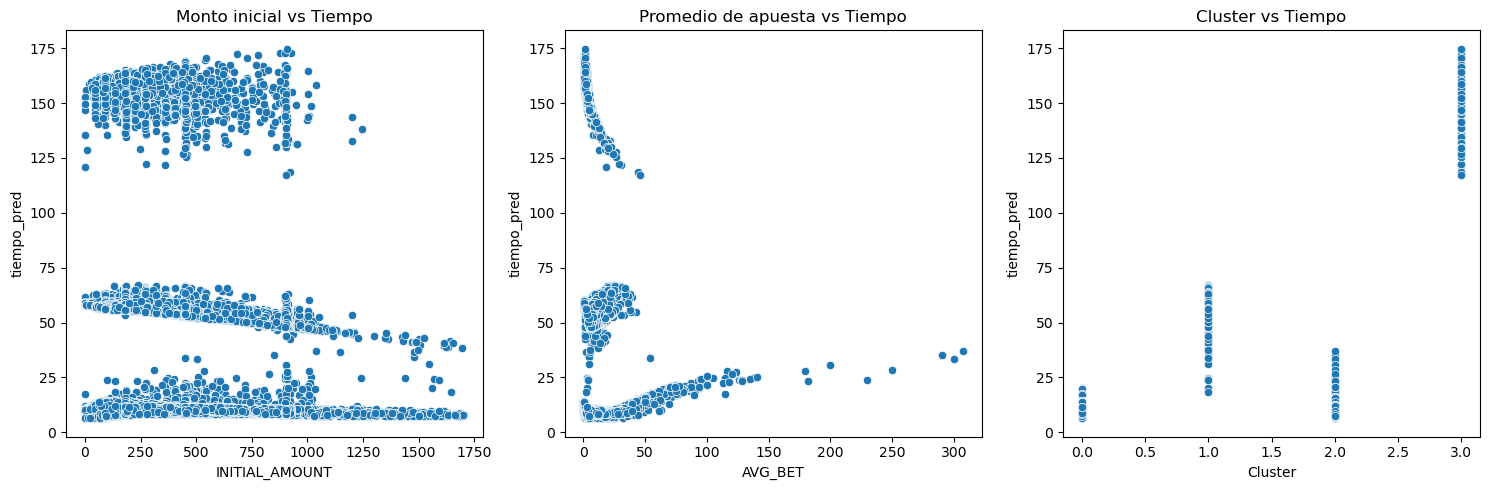

In [10]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))  # <-- aquí defines el tamaño

sns.scatterplot(x='INITIAL_AMOUNT', y='tiempo_pred', data=df, ax=axs[0])
sns.scatterplot(x='AVG_BET', y='tiempo_pred', data=df, ax=axs[1])
sns.scatterplot(x='Cluster', y='tiempo_pred', data=df, ax=axs[2])

# Títulos opcionales para cada gráfico
axs[0].set_title('Monto inicial vs Tiempo')
axs[1].set_title('Promedio de apuesta vs Tiempo')
axs[2].set_title('Cluster vs Tiempo')

plt.tight_layout()
plt.show()

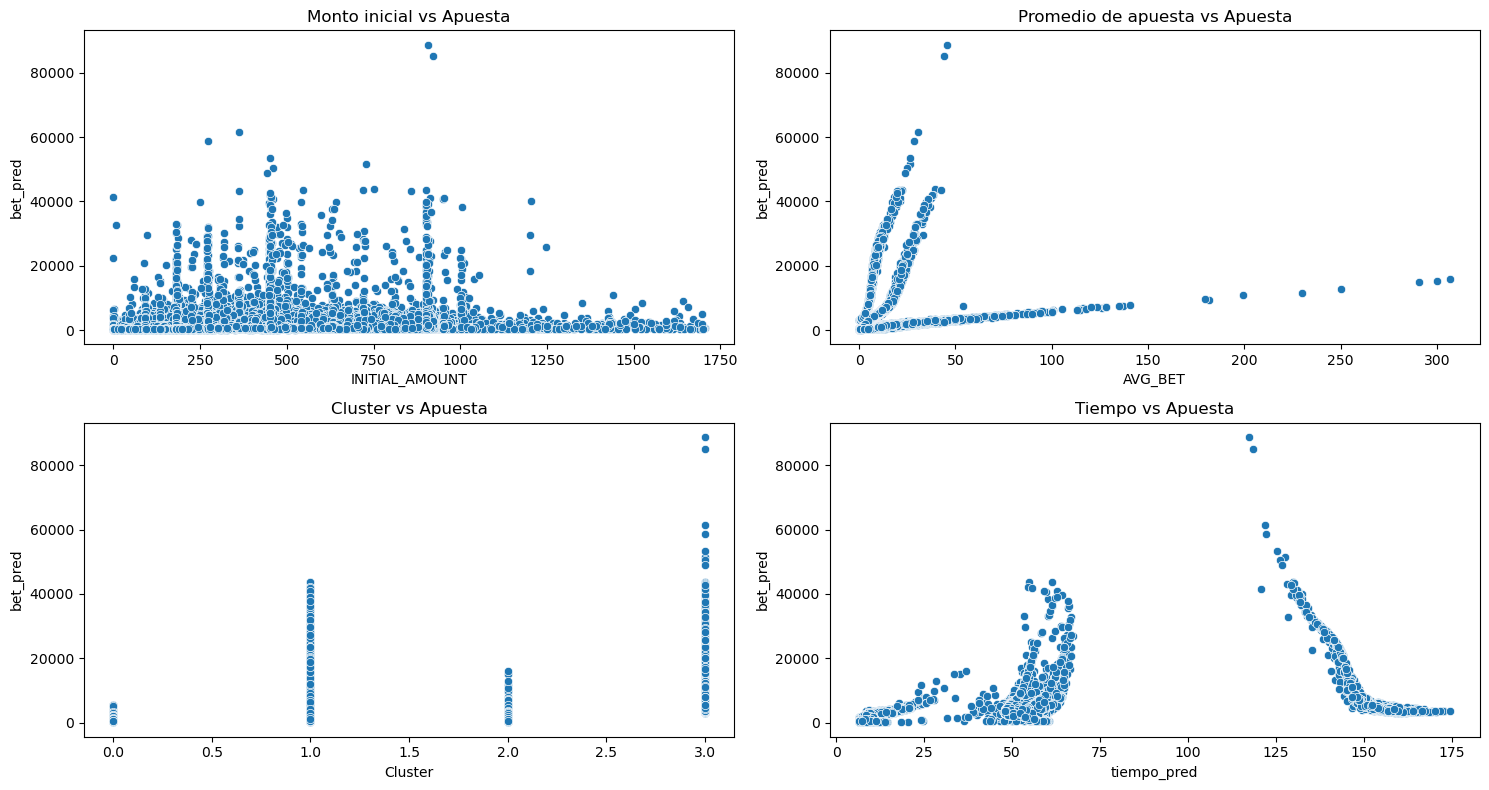

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

sns.scatterplot(x='INITIAL_AMOUNT', y='bet_pred', data=df, ax=axs[0, 0])
sns.scatterplot(x='AVG_BET', y='bet_pred', data=df, ax=axs[0, 1])
sns.scatterplot(x='Cluster', y='bet_pred', data=df, ax=axs[1, 0])
sns.scatterplot(x='tiempo_pred', y='bet_pred', data=df, ax=axs[1, 1])

# Títulos
axs[0, 0].set_title('Monto inicial vs Apuesta')
axs[0, 1].set_title('Promedio de apuesta vs Apuesta')
axs[1, 0].set_title('Cluster vs Apuesta')
axs[1, 1].set_title('Tiempo vs Apuesta')

plt.tight_layout()
plt.show()


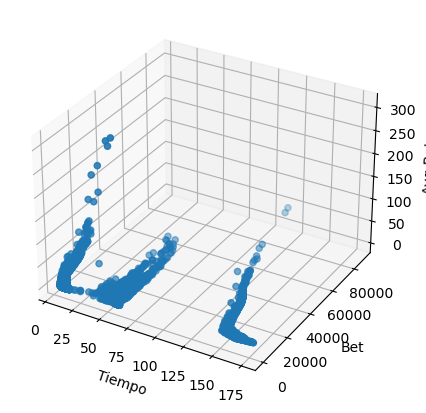

In [13]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(df['tiempo_pred'], df['bet_pred'], df['AVG_BET'])
ax.set_xlabel('Tiempo')
ax.set_ylabel('Bet')
ax.set_zlabel('Avg Bet')


plt.show()

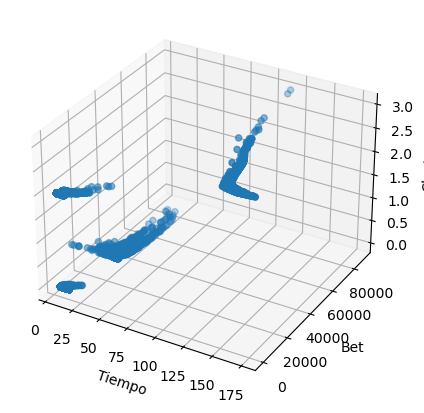

In [15]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(df['tiempo_pred'], df['bet_pred'], df['Cluster'])
ax.set_xlabel('Tiempo')
ax.set_ylabel('Bet')
ax.set_zlabel('Cluster')


plt.show()

<AxesSubplot: xlabel='tiempo_pred', ylabel='bet_pred'>

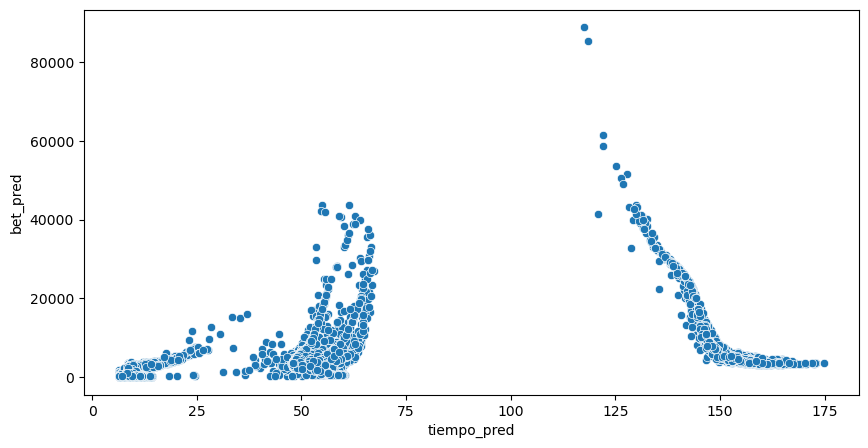

In [16]:
plt.figure(figsize=(10,5))
sns.scatterplot(df, x='tiempo_pred', y='bet_pred')

In [17]:
df_first_group = df[df['tiempo_pred'] < 30] 
df_second_group = df[(df['tiempo_pred'] > 30) & (df['tiempo_pred'] < 75)]
df_third_group = df[df['tiempo_pred'] > 75] 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209079 entries, 0 to 226732
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   INITIAL_AMOUNT  209079 non-null  float64       
 1   AVG_BET         209079 non-null  float64       
 2   Cluster         209079 non-null  int64         
 3   INITIAL_TIME    209079 non-null  datetime64[ns]
 4   Weekday         209079 non-null  int64         
 5   Weekend         209079 non-null  int64         
 6   Month           209079 non-null  int64         
 7   tiempo_pred     209079 non-null  float32       
 8   bet_pred        209079 non-null  float32       
dtypes: datetime64[ns](1), float32(2), float64(2), int64(4)
memory usage: 14.4 MB


In [19]:
import numpy as np

conditions = [
    df['tiempo_pred'] < 30,
    (df['tiempo_pred'] > 30) & (df['tiempo_pred'] < 75),
    df['tiempo_pred'] > 75
]

choices = ['Grupo 1', 'Grupo 2', 'Grupo 3']

df['Grupo'] = np.select(conditions, choices, default='Sin grupo')


/var/folders/ld/2yb_9mvs5t90r3x4r3v3btbc0000gn/T/ipykernel_2239/176981436.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# df.to_csv('time.csv')

In [21]:
df.groupby('Grupo')['bet_pred'].mean()

Grupo
Grupo 1     505.381409
Grupo 2    2411.392090
Grupo 3    7936.542969
Name: bet_pred, dtype: float32

<AxesSubplot: xlabel='Grupo', ylabel='bet_pred'>

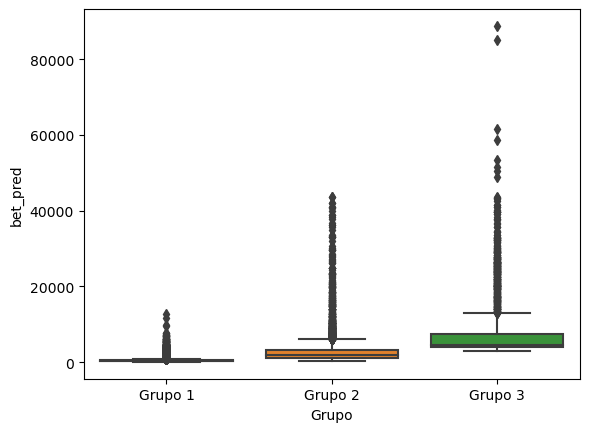

In [22]:
sns.boxplot(df, x='Grupo', y='bet_pred')

In [23]:
from scipy.stats import f_oneway

f_stat, p_val = f_oneway(
    df_first_group['tiempo_pred'],
    df_second_group['tiempo_pred'],
    df_third_group['tiempo_pred']
)

print(f"F = {f_stat:.2f}, p = {p_val:.4e}")



F = 10608849.77, p = 0.0000e+00


In [24]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['tiempo_pred'], groups=df['Grupo'], alpha=0.05)
print(tukey)


  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj  lower    upper   reject
-------------------------------------------------------
Grupo 1 Grupo 2  45.5568   0.0  45.5223  45.5913   True
Grupo 1 Grupo 3 143.0108   0.0 142.9154 143.1062   True
Grupo 2 Grupo 3   97.454   0.0  97.3537  97.5543   True
-------------------------------------------------------


In [25]:
from scipy.stats import f_oneway

f_stat, p_val = f_oneway(
    df_first_group['bet_pred'],
    df_second_group['bet_pred'],
    df_third_group['bet_pred']
)

print(f"F = {f_stat:.2f}, p = {p_val:.4e}")


F = 67774.64, p = 0.0000e+00


In [26]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['bet_pred'], groups=df['Grupo'], alpha=0.05)
print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1  group2  meandiff p-adj   lower     upper   reject
----------------------------------------------------------
Grupo 1 Grupo 2 1906.0106   0.0 1885.3626 1926.6587   True
Grupo 1 Grupo 3 7431.1618   0.0 7374.0644 7488.2591   True
Grupo 2 Grupo 3 5525.1511   0.0 5465.0938 5585.2085   True
----------------------------------------------------------


<AxesSubplot: xlabel='Grupo', ylabel='bet_pred'>

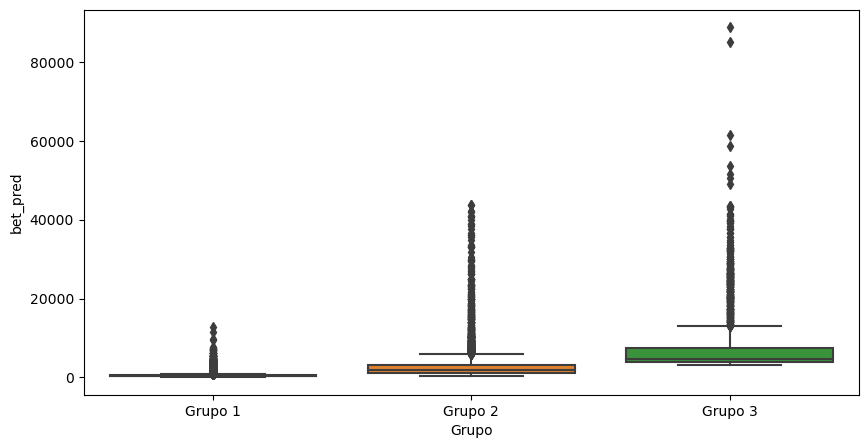

In [27]:
plt.figure(figsize=(10,5))
sns.boxplot(df, x='Grupo', y='bet_pred')

<AxesSubplot: xlabel='Grupo', ylabel='tiempo_pred'>

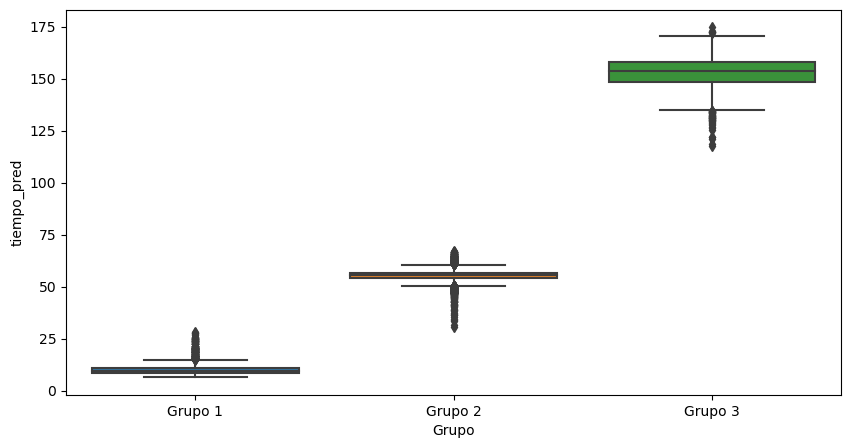

In [28]:
plt.figure(figsize=(10,5))
sns.boxplot(df, x='Grupo', y='tiempo_pred')

In [29]:
df['tiempo_pred'].describe()

count    209079.000000
mean         15.528945
std          19.706881
min           6.437281
25%           8.535267
50%           9.983807
75%          11.412752
max         174.688766
Name: tiempo_pred, dtype: float64

<AxesSubplot: xlabel='tiempo_pred'>

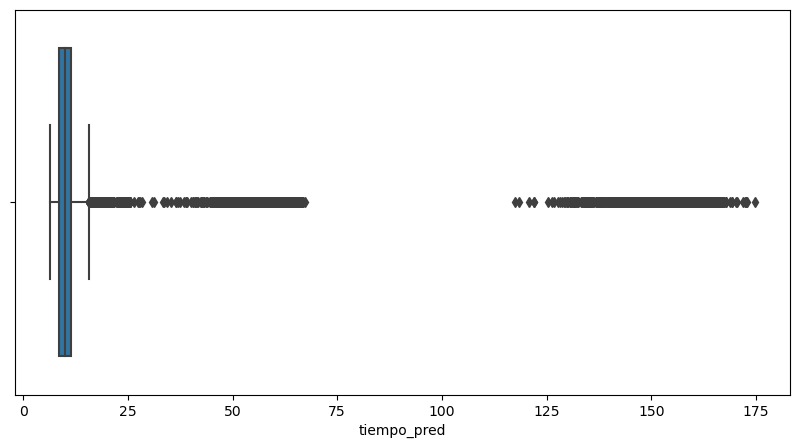

In [30]:

plt.figure(figsize=(10,5))
sns.boxplot(x=df['tiempo_pred'])

In [41]:
df_clean = remove_outliers(df, 'bet_pred')

<AxesSubplot: xlabel='tiempo_pred', ylabel='bet_pred'>

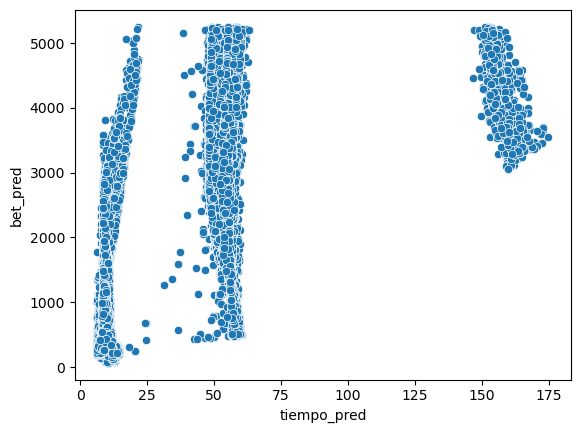

In [43]:
sns.scatterplot(df_clean, x='tiempo_pred', y='bet_pred')

<AxesSubplot: xlabel='Grupo', ylabel='bet_pred'>

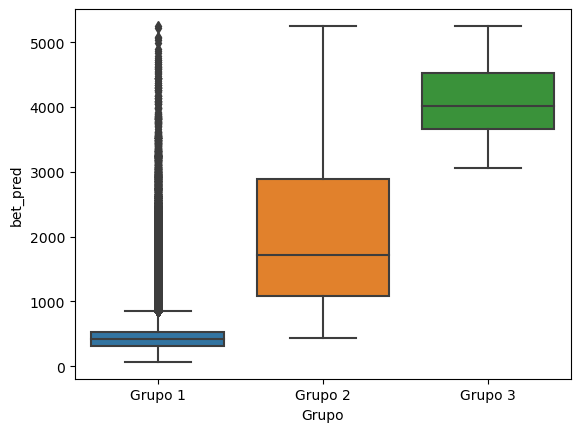

In [45]:
sns.boxplot(df_clean, x='Grupo', y='bet_pred')

In [31]:
Q1 = df['tiempo_pred'].quantile(0.25)
Q3 = df['tiempo_pred'].quantile(0.75)
IQR = Q3 - Q1

# Límite superior del bigote
upper_whisker_limit = Q3 + 1.5 * IQR

# Máximo dentro del rango permitido por el boxplot
boxplot_max = df['tiempo_pred'][df['tiempo_pred'] <= upper_whisker_limit].max()

print("Límite del bigote:", upper_whisker_limit)
print("Máximo mostrado en el boxplot:", boxplot_max)

Límite del bigote: 15.728979349136353
Máximo mostrado en el boxplot: 15.624916


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# MÉTODO 1: Detección automática de gaps en tiempo_pred
def detectar_grupos_por_gaps(df, gap_threshold=10):
    """Detecta grupos basándose en gaps naturales en tiempo_pred"""
    tiempo_sorted = np.sort(df['tiempo_pred'].unique())
    gaps = np.diff(tiempo_sorted)
    
    # Encontrar gaps significativos
    gap_indices = np.where(gaps > gap_threshold)[0]
    
    # Crear puntos de separación
    puntos_separacion = []
    for idx in gap_indices:
        punto_sep = (tiempo_sorted[idx] + tiempo_sorted[idx + 1]) / 2
        puntos_separacion.append(punto_sep)
    
    # Asignar grupos
    df_resultado = df.copy()
    df_resultado['grupo'] = 1
    
    for i, punto in enumerate(puntos_separacion):
        df_resultado.loc[df['tiempo_pred'] > punto, 'grupo'] += 1
    
    df_resultado['grupo_nombre'] = 'Grupo_' + df_resultado['grupo'].astype(str)
    df_resultado['puntos_separacion'] = str(puntos_separacion)
    
    return df_resultado, puntos_separacion

# MÉTODO 2: K-Means para identificar grupos naturales
def detectar_grupos_kmeans(df, n_clusters=3):
    """Usa K-means para detectar grupos en tiempo_pred"""
    X = df[['tiempo_pred']].values
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    grupos = kmeans.fit_predict(X)
    
    # Ordenar grupos por tiempo promedio
    centroids = kmeans.cluster_centers_.flatten()
    orden_grupos = np.argsort(centroids)
    grupos_ordenados = np.zeros_like(grupos)
    
    for i, grupo_original in enumerate(orden_grupos):
        grupos_ordenados[grupos == grupo_original] = i + 1
    
    df_resultado = df.copy()
    df_resultado['grupo_kmeans'] = grupos_ordenados
    df_resultado['grupo_kmeans_nombre'] = 'Grupo_' + df_resultado['grupo_kmeans'].astype(str)
    df_resultado['centroids'] = str(sorted(centroids))
    
    return df_resultado, sorted(centroids), kmeans

# MÉTODO 3: SVM para refinar separaciones
def refinar_separaciones_svm(df, puntos_separacion_inicial):
    """Usa SVM para refinar los puntos de separación encontrados"""
    df_resultado = df.copy()
    puntos_refinados = []
    modelos_svm = []
    
    for i, punto in enumerate(puntos_separacion_inicial):
        # Crear ventana alrededor del punto de separación
        ventana = df[(df['tiempo_pred'] >= punto - 20) & (df['tiempo_pred'] <= punto + 20)].copy()
        
        if len(ventana) < 10:  # Si hay muy pocos datos, usar el punto original
            puntos_refinados.append(punto)
            continue
            
        # Crear etiquetas binarias basadas en el punto inicial
        y = (ventana['tiempo_pred'] > punto).astype(int)
        X = ventana[['tiempo_pred']].values
        
        # Entrenar SVM
        svm = SVC(kernel='linear', C=1.0)
        svm.fit(X, y)
        
        # Calcular nuevo punto de separación
        w = svm.coef_[0][0]
        b = svm.intercept_[0]
        punto_refinado = -b / w
        
        puntos_refinados.append(punto_refinado)
        modelos_svm.append(svm)
    
    # Asignar grupos con puntos refinados
    df_resultado['grupo_svm_refinado'] = 1
    for punto in puntos_refinados:
        df_resultado.loc[df['tiempo_pred'] > punto, 'grupo_svm_refinado'] += 1
    
    df_resultado['grupo_svm_nombre'] = 'Grupo_' + df_resultado['grupo_svm_refinado'].astype(str)
    df_resultado['puntos_svm_refinados'] = str(puntos_refinados)
    
    return df_resultado, puntos_refinados, modelos_svm

# FUNCIÓN PRINCIPAL INTEGRADA
def detectar_grupos_automatico(df, metodo='auto', n_clusters=3, gap_threshold=10):
    """
    Detecta automáticamente los grupos en los datos
    metodo: 'gaps', 'kmeans', 'auto' (combina gaps + SVM)
    """
    print("=== DETECCIÓN AUTOMÁTICA DE GRUPOS ===\n")
    
    if metodo == 'gaps' or metodo == 'auto':
        # Paso 1: Detectar por gaps
        df_gaps, puntos_gaps = detectar_grupos_por_gaps(df, gap_threshold)
        print(f"GAPS DETECTADOS: {len(puntos_gaps)} separaciones")
        print(f"Puntos de separación: {[f'{p:.2f}' for p in puntos_gaps]}")
        print(f"Distribución por grupos: {df_gaps['grupo'].value_counts().sort_index().to_dict()}\n")
        
        if metodo == 'auto':
            # Paso 2: Refinar con SVM
            df_final, puntos_refinados, modelos = refinar_separaciones_svm(df, puntos_gaps)
            print(f"PUNTOS REFINADOS CON SVM: {[f'{p:.2f}' for p in puntos_refinados]}")
            print(f"Distribución final: {df_final['grupo_svm_refinado'].value_counts().sort_index().to_dict()}\n")
        else:
            df_final = df_gaps
            puntos_refinados = puntos_gaps
            modelos = None
    
    elif metodo == 'kmeans':
        # Solo K-means
        df_final, centroids, modelo_kmeans = detectar_grupos_kmeans(df, n_clusters)
        puntos_refinados = [(centroids[i] + centroids[i+1])/2 for i in range(len(centroids)-1)]
        modelos = modelo_kmeans
        print(f"K-MEANS: {n_clusters} clusters")
        print(f"Centroids: {[f'{c:.2f}' for c in centroids]}")
        print(f"Distribución: {df_final['grupo_kmeans'].value_counts().sort_index().to_dict()}\n")
    
    return df_final, puntos_refinados, modelos

# ANÁLISIS ESTADÍSTICO DE GRUPOS
def analizar_grupos(df_final, columna_grupo='grupo_svm_refinado'):
    """Analiza las características de cada grupo detectado"""
    print("=== ANÁLISIS ESTADÍSTICO POR GRUPO ===\n")
    
    grupos_stats = df_final.groupby(columna_grupo).agg({
        'tiempo_pred': ['count', 'min', 'max', 'mean', 'std'],
        'bet_pred': ['min', 'max', 'mean', 'std', 'median']
    }).round(2)
    
    print("Estadísticas por grupo:")
    print(grupos_stats)
    
    return grupos_stats

# VISUALIZACIÓN COMPLETA
def visualizar_grupos_detectados(df_final, puntos_separacion, columna_grupo='grupo_svm_refinado'):
    """Visualiza los grupos detectados automáticamente"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    grupos = df_final[columna_grupo]
    n_grupos = len(grupos.unique())
    colores = plt.cm.Set1(np.linspace(0, 1, n_grupos))
    
    # Gráfico 1: Distribución temporal con separaciones
    ax1 = axes[0, 0]
    for i, grupo in enumerate(sorted(grupos.unique())):
        datos_grupo = df_final[df_final[columna_grupo] == grupo]
        ax1.scatter(datos_grupo['tiempo_pred'], [i+1]*len(datos_grupo), 
                   c=[colores[i]], label=f'Grupo {grupo}', alpha=0.6)
    
    for punto in puntos_separacion:
        ax1.axvline(x=punto, color='red', linestyle='--', alpha=0.8)
    
    ax1.set_xlabel('tiempo_pred')
    ax1.set_ylabel('Grupos')
    ax1.set_title('Distribución Temporal de Grupos')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico 2: Scatter original con grupos coloreados
    ax2 = axes[0, 1]
    for i, grupo in enumerate(sorted(grupos.unique())):
        datos_grupo = df_final[df_final[columna_grupo] == grupo]
        ax2.scatter(datos_grupo['tiempo_pred'], datos_grupo['bet_pred'], 
                   c=[colores[i]], label=f'Grupo {grupo}', alpha=0.7)
    
    for punto in puntos_separacion:
        ax2.axvline(x=punto, color='red', linestyle='--', alpha=0.8, linewidth=2)
    
    ax2.set_xlabel('tiempo_pred')
    ax2.set_ylabel('bet_pred')
    ax2.set_title('Scatter Plot con Grupos Detectados')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Gráfico 3: Boxplots por grupo
    ax3 = axes[1, 0]
    boxplot_data = [df_final[df_final[columna_grupo] == grupo]['tiempo_pred'].values 
                    for grupo in sorted(grupos.unique())]
    bp = ax3.boxplot(boxplot_data, labels=[f'Grupo {g}' for g in sorted(grupos.unique())])
    ax3.set_ylabel('tiempo_pred')
    ax3.set_title('Distribución de tiempo_pred por Grupo')
    ax3.grid(True, alpha=0.3)
    
    # Gráfico 4: Histograma de bet_pred por grupo
    ax4 = axes[1, 1]
    for i, grupo in enumerate(sorted(grupos.unique())):
        datos_grupo = df_final[df_final[columna_grupo] == grupo]['bet_pred']
        ax4.hist(datos_grupo, bins=20, alpha=0.6, label=f'Grupo {grupo}', color=colores[i])
    
    ax4.set_xlabel('bet_pred')
    ax4.set_ylabel('Frecuencia')
    ax4.set_title('Distribución de bet_pred por Grupo')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# FUNCIÓN DE USO FÁCIL
def procesar_datos_completo(df):
    """Función todo-en-uno para procesar los datos"""
    
    # 1. Detección automática
    df_resultado, puntos_separacion, modelos = detectar_grupos_automatico(df, metodo='auto')
    
    # 2. Análisis estadístico  
    stats = analizar_grupos(df_resultado)
    
    # 3. Visualización
    visualizar_grupos_detectados(df_resultado, puntos_separacion)
    
    # 4. Crear resumen
    resumen = {
        'dataframe_con_grupos': df_resultado,
        'puntos_separacion': puntos_separacion,
        'estadisticas_grupos': stats,
        'modelos_svm': modelos,
        'n_grupos': len(df_resultado['grupo_svm_refinado'].unique())
    }
    
    return resumen

# EJEMPLO DE USO SIMPLE
"""
# Para usar con tus datos:
resultado = procesar_datos_completo(df)

# Acceder a los resultados
df_con_grupos = resultado['dataframe_con_grupos']
puntos_de_corte = resultado['puntos_separacion']

print(f"Se detectaron {resultado['n_grupos']} grupos")
print(f"Puntos de separación: {puntos_de_corte}")

# Guardar resultados
df_con_grupos.to_csv('datos_con_grupos_automaticos.csv', index=False)

# Ver grupos específicos
grupo_1 = df_con_grupos[df_con_grupos['grupo_svm_refinado'] == 1]
grupo_2 = df_con_grupos[df_con_grupos['grupo_svm_refinado'] == 2]
grupo_3 = df_con_grupos[df_con_grupos['grupo_svm_refinado'] == 3]
"""

'\n# Para usar con tus datos:\nresultado = procesar_datos_completo(df)\n\n# Acceder a los resultados\ndf_con_grupos = resultado[\'dataframe_con_grupos\']\npuntos_de_corte = resultado[\'puntos_separacion\']\n\nprint(f"Se detectaron {resultado[\'n_grupos\']} grupos")\nprint(f"Puntos de separación: {puntos_de_corte}")\n\n# Guardar resultados\ndf_con_grupos.to_csv(\'datos_con_grupos_automaticos.csv\', index=False)\n\n# Ver grupos específicos\ngrupo_1 = df_con_grupos[df_con_grupos[\'grupo_svm_refinado\'] == 1]\ngrupo_2 = df_con_grupos[df_con_grupos[\'grupo_svm_refinado\'] == 2]\ngrupo_3 = df_con_grupos[df_con_grupos[\'grupo_svm_refinado\'] == 3]\n'

=== DETECCIÓN AUTOMÁTICA DE GRUPOS ===

GAPS DETECTADOS: 1 separaciones
Puntos de separación: ['92.32']
Distribución por grupos: {1: 206763, 2: 2316}

PUNTOS REFINADOS CON SVM: ['92.32']
Distribución final: {1: 206763, 2: 2316}

=== ANÁLISIS ESTADÍSTICO POR GRUPO ===

Estadísticas por grupo:
                   tiempo_pred                                         \
                         count         min         max    mean    std   
grupo_svm_refinado                                                      
1                       206763    6.440000   67.250000   13.99  13.37   
2                         2316  117.389999  174.690002  152.75   7.06   

                       bet_pred                                      \
                            min           max         mean      std   
grupo_svm_refinado                                                    
1                     65.879997  43735.960938   683.239990   991.93   
2                   3061.179932  88789.703125  7936.54003

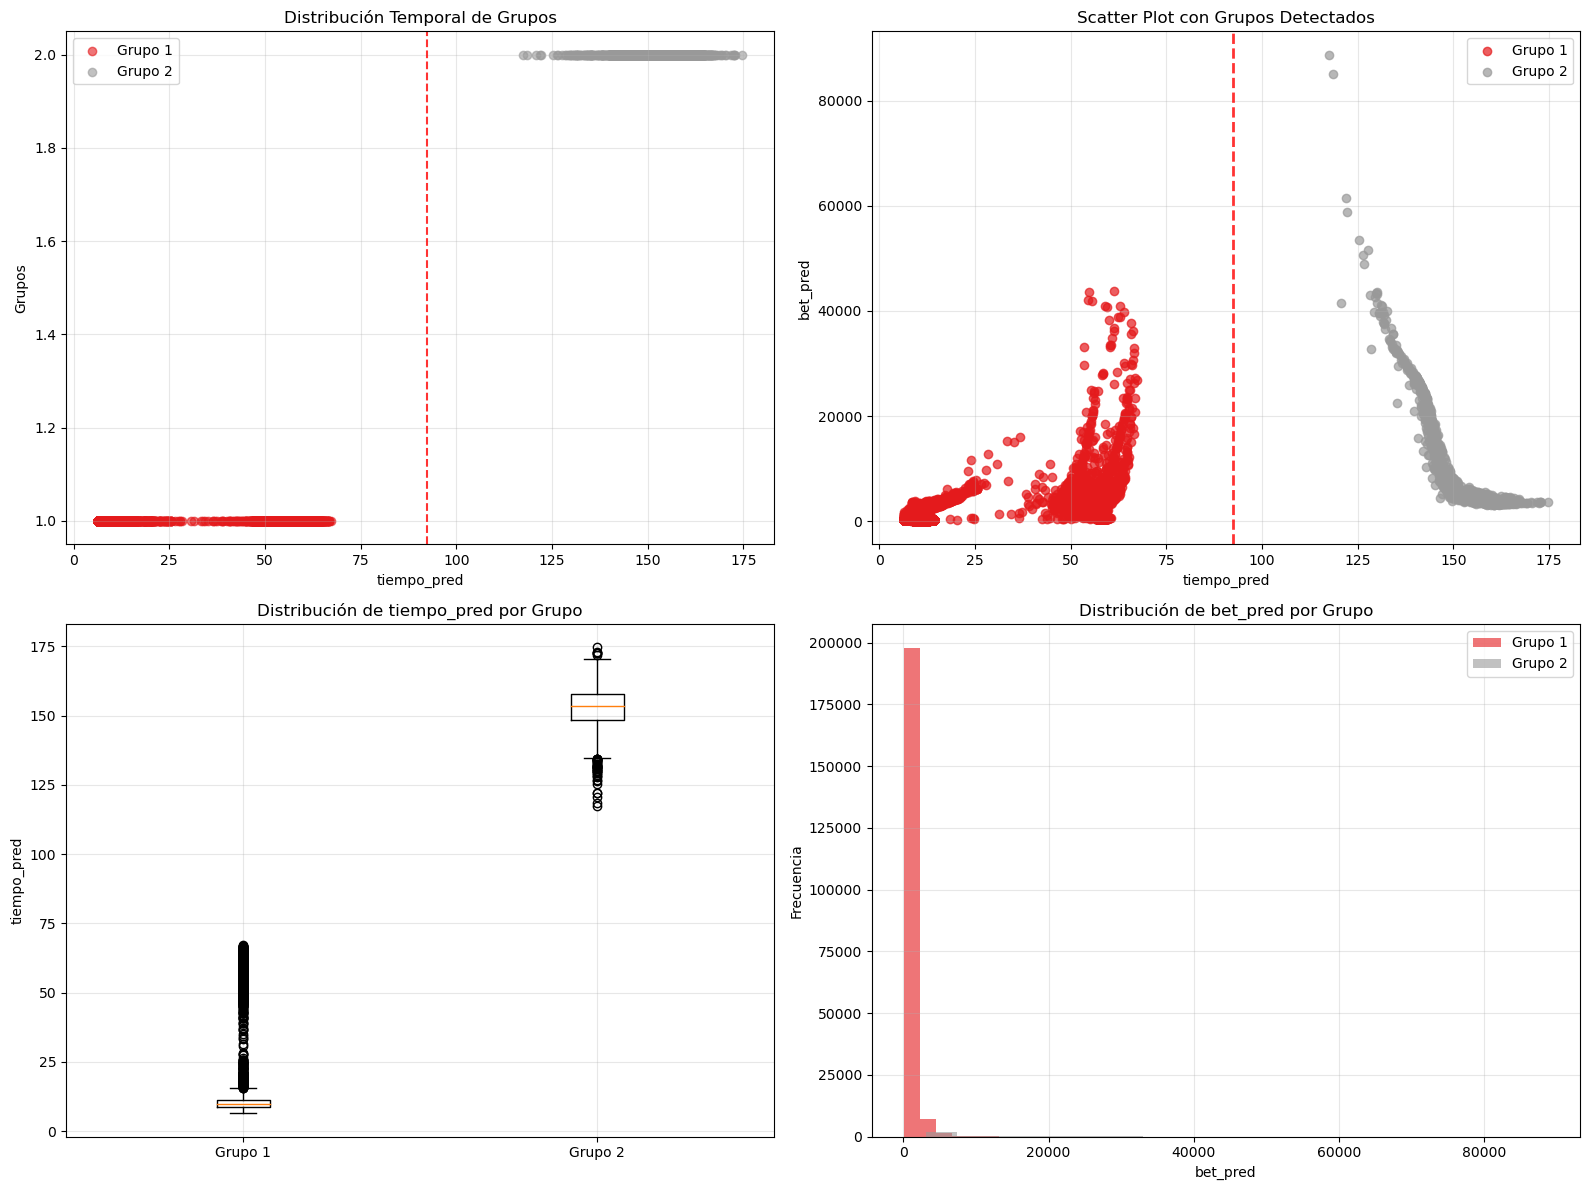

In [33]:
resultado = procesar_datos_completo(df)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# MÉTODO 1: Detección automática de gaps en tiempo_pred
def detectar_grupos_por_gaps(df, gap_threshold=10):
    """Detecta grupos basándose en gaps naturales en tiempo_pred"""
    tiempo_sorted = np.sort(df['tiempo_pred'].unique())
    gaps = np.diff(tiempo_sorted)
    
    # Encontrar gaps significativos
    gap_indices = np.where(gaps > gap_threshold)[0]
    
    # Crear puntos de separación
    puntos_separacion = []
    for idx in gap_indices:
        punto_sep = (tiempo_sorted[idx] + tiempo_sorted[idx + 1]) / 2
        puntos_separacion.append(punto_sep)
    
    # Asignar grupos
    df_resultado = df.copy()
    df_resultado['grupo'] = 1
    
    for i, punto in enumerate(puntos_separacion):
        df_resultado.loc[df['tiempo_pred'] > punto, 'grupo'] += 1
    
    df_resultado['grupo_nombre'] = 'Grupo_' + df_resultado['grupo'].astype(str)
    df_resultado['puntos_separacion'] = str(puntos_separacion)
    
    return df_resultado, puntos_separacion

# MÉTODO 2: K-Means para identificar grupos naturales
def detectar_grupos_kmeans(df, n_clusters=3):
    """Usa K-means para detectar grupos en tiempo_pred"""
    X = df[['tiempo_pred']].values
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    grupos = kmeans.fit_predict(X)
    
    # Ordenar grupos por tiempo promedio
    centroids = kmeans.cluster_centers_.flatten()
    orden_grupos = np.argsort(centroids)
    grupos_ordenados = np.zeros_like(grupos)
    
    for i, grupo_original in enumerate(orden_grupos):
        grupos_ordenados[grupos == grupo_original] = i + 1
    
    df_resultado = df.copy()
    df_resultado['grupo_kmeans'] = grupos_ordenados
    df_resultado['grupo_kmeans_nombre'] = 'Grupo_' + df_resultado['grupo_kmeans'].astype(str)
    df_resultado['centroids'] = str(sorted(centroids))
    
    return df_resultado, sorted(centroids), kmeans

# MÉTODO 3: SVM para refinar separaciones
def refinar_separaciones_svm(df, puntos_separacion_inicial):
    """Usa SVM para refinar los puntos de separación encontrados"""
    df_resultado = df.copy()
    puntos_refinados = []
    modelos_svm = []
    
    for i, punto in enumerate(puntos_separacion_inicial):
        # Crear ventana alrededor del punto de separación
        ventana = df[(df['tiempo_pred'] >= punto - 20) & (df['tiempo_pred'] <= punto + 20)].copy()
        
        if len(ventana) < 10:  # Si hay muy pocos datos, usar el punto original
            puntos_refinados.append(punto)
            continue
            
        # Crear etiquetas binarias basadas en el punto inicial
        y = (ventana['tiempo_pred'] > punto).astype(int)
        X = ventana[['tiempo_pred']].values
        
        # Entrenar SVM
        svm = SVC(kernel='linear', C=1.0)
        svm.fit(X, y)
        
        # Calcular nuevo punto de separación
        w = svm.coef_[0][0]
        b = svm.intercept_[0]
        punto_refinado = -b / w
        
        puntos_refinados.append(punto_refinado)
        modelos_svm.append(svm)
    
    # Asignar grupos con puntos refinados
    df_resultado['grupo_svm_refinado'] = 1
    for punto in puntos_refinados:
        df_resultado.loc[df['tiempo_pred'] > punto, 'grupo_svm_refinado'] += 1
    
    df_resultado['grupo_svm_nombre'] = 'Grupo_' + df_resultado['grupo_svm_refinado'].astype(str)
    df_resultado['puntos_svm_refinados'] = str(puntos_refinados)
    
    return df_resultado, puntos_refinados, modelos_svm

# FUNCIÓN PRINCIPAL INTEGRADA
def detectar_grupos_automatico(df, metodo='auto', n_clusters=3, gap_threshold=10):
    """
    Detecta automáticamente los grupos en los datos
    metodo: 'gaps', 'kmeans', 'auto' (combina gaps + SVM)
    """
    print("=== DETECCIÓN AUTOMÁTICA DE GRUPOS ===\n")
    
    if metodo == 'gaps' or metodo == 'auto':
        # Paso 1: Detectar por gaps
        df_gaps, puntos_gaps = detectar_grupos_por_gaps(df, gap_threshold)
        print(f"GAPS DETECTADOS: {len(puntos_gaps)} separaciones")
        print(f"Puntos de separación: {[f'{p:.2f}' for p in puntos_gaps]}")
        print(f"Distribución por grupos: {df_gaps['grupo'].value_counts().sort_index().to_dict()}\n")
        
        if metodo == 'auto':
            # Paso 2: Refinar con SVM
            df_final, puntos_refinados, modelos = refinar_separaciones_svm(df, puntos_gaps)
            print(f"PUNTOS REFINADOS CON SVM: {[f'{p:.2f}' for p in puntos_refinados]}")
            print(f"Distribución final: {df_final['grupo_svm_refinado'].value_counts().sort_index().to_dict()}\n")
        else:
            df_final = df_gaps
            puntos_refinados = puntos_gaps
            modelos = None
    
    elif metodo == 'kmeans':
        # Solo K-means
        df_final, centroids, modelo_kmeans = detectar_grupos_kmeans(df, n_clusters)
        puntos_refinados = [(centroids[i] + centroids[i+1])/2 for i in range(len(centroids)-1)]
        modelos = modelo_kmeans
        print(f"K-MEANS: {n_clusters} clusters")
        print(f"Centroids: {[f'{c:.2f}' for c in centroids]}")
        print(f"Distribución: {df_final['grupo_kmeans'].value_counts().sort_index().to_dict()}\n")
    
    return df_final, puntos_refinados, modelos

# ANÁLISIS ESTADÍSTICO DE GRUPOS
def analizar_grupos(df_final, columna_grupo='grupo_svm_refinado'):
    """Analiza las características de cada grupo detectado"""
    print("=== ANÁLISIS ESTADÍSTICO POR GRUPO ===\n")
    
    grupos_stats = df_final.groupby(columna_grupo).agg({
        'tiempo_pred': ['count', 'min', 'max', 'mean', 'std'],
        'bet_pred': ['min', 'max', 'mean', 'std', 'median']
    }).round(2)
    
    print("Estadísticas por grupo:")
    print(grupos_stats)
    
    return grupos_stats

# VISUALIZACIÓN COMPLETA
def visualizar_grupos_detectados(df_final, puntos_separacion, columna_grupo='grupo_svm_refinado'):
    """Visualiza los grupos detectados automáticamente"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    grupos = df_final[columna_grupo]
    n_grupos = len(grupos.unique())
    colores = plt.cm.Set1(np.linspace(0, 1, n_grupos))
    
    # Gráfico 1: Distribución temporal con separaciones
    ax1 = axes[0, 0]
    for i, grupo in enumerate(sorted(grupos.unique())):
        datos_grupo = df_final[df_final[columna_grupo] == grupo]
        ax1.scatter(datos_grupo['tiempo_pred'], [i+1]*len(datos_grupo), 
                   c=[colores[i]], label=f'Grupo {grupo}', alpha=0.6)
    
    for punto in puntos_separacion:
        ax1.axvline(x=punto, color='red', linestyle='--', alpha=0.8)
    
    ax1.set_xlabel('tiempo_pred')
    ax1.set_ylabel('Grupos')
    ax1.set_title('Distribución Temporal de Grupos')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico 2: Scatter original con grupos coloreados
    ax2 = axes[0, 1]
    for i, grupo in enumerate(sorted(grupos.unique())):
        datos_grupo = df_final[df_final[columna_grupo] == grupo]
        ax2.scatter(datos_grupo['tiempo_pred'], datos_grupo['bet_pred'], 
                   c=[colores[i]], label=f'Grupo {grupo}', alpha=0.7)
    
    for punto in puntos_separacion:
        ax2.axvline(x=punto, color='red', linestyle='--', alpha=0.8, linewidth=2)
    
    ax2.set_xlabel('tiempo_pred')
    ax2.set_ylabel('bet_pred')
    ax2.set_title('Scatter Plot con Grupos Detectados')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Gráfico 3: Boxplots por grupo
    ax3 = axes[1, 0]
    boxplot_data = [df_final[df_final[columna_grupo] == grupo]['tiempo_pred'].values 
                    for grupo in sorted(grupos.unique())]
    bp = ax3.boxplot(boxplot_data, labels=[f'Grupo {g}' for g in sorted(grupos.unique())])
    ax3.set_ylabel('tiempo_pred')
    ax3.set_title('Distribución de tiempo_pred por Grupo')
    ax3.grid(True, alpha=0.3)
    
    # Gráfico 4: Histograma de bet_pred por grupo
    ax4 = axes[1, 1]
    for i, grupo in enumerate(sorted(grupos.unique())):
        datos_grupo = df_final[df_final[columna_grupo] == grupo]['bet_pred']
        ax4.hist(datos_grupo, bins=20, alpha=0.6, label=f'Grupo {grupo}', color=colores[i])
    
    ax4.set_xlabel('bet_pred')
    ax4.set_ylabel('Frecuencia')
    ax4.set_title('Distribución de bet_pred por Grupo')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# FUNCIÓN DE USO FÁCIL
def procesar_datos_completo(df):
    """Función todo-en-uno para procesar los datos"""
    
    # 1. Detección automática
    df_resultado, puntos_separacion, modelos = detectar_grupos_automatico(df, metodo='auto')
    
    # 2. Análisis estadístico  
    stats = analizar_grupos(df_resultado)
    
    # 3. Visualización
    visualizar_grupos_detectados(df_resultado, puntos_separacion)
    
    # 4. Crear resumen
    resumen = {
        'dataframe_con_grupos': df_resultado,
        'puntos_separacion': puntos_separacion,
        'estadisticas_grupos': stats,
        'modelos_svm': modelos,
        'n_grupos': len(df_resultado['grupo_svm_refinado'].unique())
    }
    
    return resumen

# ANÁLISIS DETALLADO DE LÍMITES ENTRE GRUPOS
def analizar_limites_grupos(df_final, puntos_separacion, tolerancia=5, columna_grupo='grupo_svm_refinado'):
    """
    Analiza en detalle los límites entre grupos
    tolerancia: distancia desde el punto de separación para considerar como 'en el límite'
    """
    print("=== ANÁLISIS DETALLADO DE LÍMITES ENTRE GRUPOS ===\n")
    
    limites_info = {}
    datos_en_limites = []
    
    for i, punto_separacion in enumerate(puntos_separacion):
        limite_id = f"Limite_{i+1}_to_{i+2}"
        
        # Encontrar datos cerca del límite
        cerca_limite = df_final[
            np.abs(df_final['tiempo_pred'] - punto_separacion) <= tolerancia
        ].copy()
        
        # Agregar información del límite
        cerca_limite['limite_id'] = limite_id
        cerca_limite['punto_separacion'] = punto_separacion
        cerca_limite['distancia_al_limite'] = np.abs(cerca_limite['tiempo_pred'] - punto_separacion)
        
        # Estadísticas del límite
        if len(cerca_limite) > 0:
            grupo_izq = cerca_limite[cerca_limite['tiempo_pred'] <= punto_separacion][columna_grupo].iloc[0] if len(cerca_limite[cerca_limite['tiempo_pred'] <= punto_separacion]) > 0 else None
            grupo_der = cerca_limite[cerca_limite['tiempo_pred'] > punto_separacion][columna_grupo].iloc[0] if len(cerca_limite[cerca_limite['tiempo_pred'] > punto_separacion]) > 0 else None
            
            limites_info[limite_id] = {
                'punto_separacion': punto_separacion,
                'grupo_izquierdo': grupo_izq,
                'grupo_derecho': grupo_der,
                'n_datos_en_limite': len(cerca_limite),
                'tiempo_min_limite': cerca_limite['tiempo_pred'].min(),
                'tiempo_max_limite': cerca_limite['tiempo_pred'].max(),
                'bet_pred_promedio_limite': cerca_limite['bet_pred'].mean(),
                'bet_pred_std_limite': cerca_limite['bet_pred'].std()
            }
            
            print(f"{limite_id}:")
            print(f"  Punto de separación: {punto_separacion:.2f}")
            print(f"  Entre Grupo {grupo_izq} y Grupo {grupo_der}")
            print(f"  Datos en el límite (±{tolerancia}): {len(cerca_limite)}")
            print(f"  Rango temporal del límite: {cerca_limite['tiempo_pred'].min():.2f} - {cerca_limite['tiempo_pred'].max():.2f}")
            print(f"  bet_pred promedio en límite: {cerca_limite['bet_pred'].mean():.2f} ± {cerca_limite['bet_pred'].std():.2f}")
            print()
            
            datos_en_limites.append(cerca_limite)
    
    # Combinar todos los datos en límites
    if datos_en_limites:
        df_limites = pd.concat(datos_en_limites, ignore_index=True)
    else:
        df_limites = pd.DataFrame()
    
    return limites_info, df_limites

def encontrar_datos_extremos_por_grupo(df_final, columna_grupo='grupo_svm_refinado', n_extremos=5):
    """Encuentra los datos más cercanos y más lejanos a los límites en cada grupo"""
    print("=== DATOS EXTREMOS POR GRUPO ===\n")
    
    grupos_extremos = {}
    
    for grupo in sorted(df_final[columna_grupo].unique()):
        datos_grupo = df_final[df_final[columna_grupo] == grupo].copy()
        
        # Ordenar por tiempo_pred
        datos_grupo = datos_grupo.sort_values('tiempo_pred')
        
        extremos_info = {
            'grupo': grupo,
            'n_total': len(datos_grupo),
            'tiempo_min': datos_grupo['tiempo_pred'].min(),
            'tiempo_max': datos_grupo['tiempo_pred'].max(),
            'primeros_n': datos_grupo.head(n_extremos),  # Menores tiempo_pred
            'ultimos_n': datos_grupo.tail(n_extremos)    # Mayores tiempo_pred
        }
        
        grupos_extremos[grupo] = extremos_info
        
        print(f"GRUPO {grupo}:")
        print(f"  Total de datos: {len(datos_grupo)}")
        print(f"  Rango temporal: {datos_grupo['tiempo_pred'].min():.2f} - {datos_grupo['tiempo_pred'].max():.2f}")
        print(f"  Primeros {n_extremos} datos (menor tiempo):")
        for _, row in datos_grupo.head(n_extremos).iterrows():
            print(f"    tiempo: {row['tiempo_pred']:.2f}, bet_pred: {row['bet_pred']:.2f}")
        print(f"  Últimos {n_extremos} datos (mayor tiempo):")
        for _, row in datos_grupo.tail(n_extremos).iterrows():
            print(f"    tiempo: {row['tiempo_pred']:.2f}, bet_pred: {row['bet_pred']:.2f}")
        print()
    
    return grupos_extremos

def visualizar_limites_detallado(df_final, limites_info, df_limites, puntos_separacion, columna_grupo='grupo_svm_refinado'):
    """Visualización específica de los límites entre grupos"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    grupos = df_final[columna_grupo]
    n_grupos = len(grupos.unique())
    colores = plt.cm.Set1(np.linspace(0, 1, n_grupos))
    
    # Gráfico 1: Vista general con zonas de límite resaltadas
    ax1 = axes[0, 0]
    for i, grupo in enumerate(sorted(grupos.unique())):
        datos_grupo = df_final[df_final[columna_grupo] == grupo]
        ax1.scatter(datos_grupo['tiempo_pred'], datos_grupo['bet_pred'], 
                   c=[colores[i]], label=f'Grupo {grupo}', alpha=0.6, s=20)
    
    # Resaltar zonas de límite
    for punto in puntos_separacion:
        ax1.axvline(x=punto, color='red', linestyle='--', alpha=0.8, linewidth=2)
        ax1.axvspan(punto-5, punto+5, alpha=0.2, color='red')
    
    # Resaltar datos en límites
    if not df_limites.empty:
        ax1.scatter(df_limites['tiempo_pred'], df_limites['bet_pred'], 
                   c='red', marker='x', s=100, label='Datos en límites')
    
    ax1.set_xlabel('tiempo_pred')
    ax1.set_ylabel('bet_pred')
    ax1.set_title('Vista General con Zonas de Límite')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico 2: Zoom a cada límite
    if len(puntos_separacion) > 0:
        ax2 = axes[0, 1]
        for i, punto in enumerate(puntos_separacion):
            ventana = df_final[
                (df_final['tiempo_pred'] >= punto - 15) & 
                (df_final['tiempo_pred'] <= punto + 15)
            ]
            
            for j, grupo in enumerate(sorted(ventana[columna_grupo].unique())):
                datos_ventana = ventana[ventana[columna_grupo] == grupo]
                ax2.scatter(datos_ventana['tiempo_pred'], datos_ventana['bet_pred'], 
                           c=[colores[j]], label=f'Grupo {grupo}', alpha=0.7)
            
            ax2.axvline(x=punto, color='red', linestyle='--', linewidth=2, 
                       label=f'Límite {i+1}' if i == 0 else "")
        
        ax2.set_xlabel('tiempo_pred')
        ax2.set_ylabel('bet_pred')
        ax2.set_title('Zoom en Zonas de Límite')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Gráfico 3: Distribución de distancias a límites
    ax3 = axes[1, 0]
    if not df_limites.empty:
        for limite_id in df_limites['limite_id'].unique():
            datos_limite = df_limites[df_limites['limite_id'] == limite_id]
            ax3.hist(datos_limite['distancia_al_limite'], bins=10, alpha=0.6, 
                    label=limite_id)
        
        ax3.set_xlabel('Distancia al límite')
        ax3.set_ylabel('Frecuencia')
        ax3.set_title('Distribución de Distancias a Límites')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Gráfico 4: Tabla resumen de límites
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    if limites_info:
        tabla_data = []
        for limite_id, info in limites_info.items():
            tabla_data.append([
                limite_id,
                f"{info['punto_separacion']:.2f}",
                f"G{info['grupo_izquierdo']}-G{info['grupo_derecho']}",
                f"{info['n_datos_en_limite']}",
                f"{info['bet_pred_promedio_limite']:.0f}"
            ])
        
        tabla = ax4.table(cellText=tabla_data,
                         colLabels=['Límite', 'Punto Sep.', 'Entre Grupos', 'N° Datos', 'Bet Prom.'],
                         cellLoc='center',
                         loc='center')
        tabla.auto_set_font_size(False)
        tabla.set_fontsize(10)
        tabla.scale(1, 2)
        ax4.set_title('Resumen de Límites')
    
    plt.tight_layout()
    plt.show()

def analisis_completo_limites(df_final, puntos_separacion, tolerancia=5, n_extremos=5):
    """Función todo-en-uno para análisis completo de límites"""
    print("🔍 ANÁLISIS COMPLETO DE LÍMITES ENTRE GRUPOS 🔍\n")
    
    # 1. Análisis de límites
    limites_info, df_limites = analizar_limites_grupos(df_final, puntos_separacion, tolerancia)
    
    # 2. Datos extremos por grupo
    grupos_extremos = encontrar_datos_extremos_por_grupo(df_final, n_extremos=n_extremos)
    
    # 3. Visualización
    visualizar_limites_detallado(df_final, limites_info, df_limites, puntos_separacion)
    
    # 4. Resumen ejecutivo
    print("=== RESUMEN EJECUTIVO ===")
    print(f"Total de límites detectados: {len(puntos_separacion)}")
    if not df_limites.empty:
        print(f"Total de datos en zonas límite (±{tolerancia}): {len(df_limites)}")
        print(f"Porcentaje de datos en límites: {len(df_limites)/len(df_final)*100:.1f}%")
    
    return {
        'limites_info': limites_info,
        'datos_en_limites': df_limites,
        'grupos_extremos': grupos_extremos
    }


=== DETECCIÓN AUTOMÁTICA DE GRUPOS ===

GAPS DETECTADOS: 1 separaciones
Puntos de separación: ['92.32']
Distribución por grupos: {1: 206763, 2: 2316}

PUNTOS REFINADOS CON SVM: ['92.32']
Distribución final: {1: 206763, 2: 2316}

=== ANÁLISIS ESTADÍSTICO POR GRUPO ===

Estadísticas por grupo:
                   tiempo_pred                                         \
                         count         min         max    mean    std   
grupo_svm_refinado                                                      
1                       206763    6.440000   67.250000   13.99  13.37   
2                         2316  117.389999  174.690002  152.75   7.06   

                       bet_pred                                      \
                            min           max         mean      std   
grupo_svm_refinado                                                    
1                     65.879997  43735.960938   683.239990   991.93   
2                   3061.179932  88789.703125  7936.54003

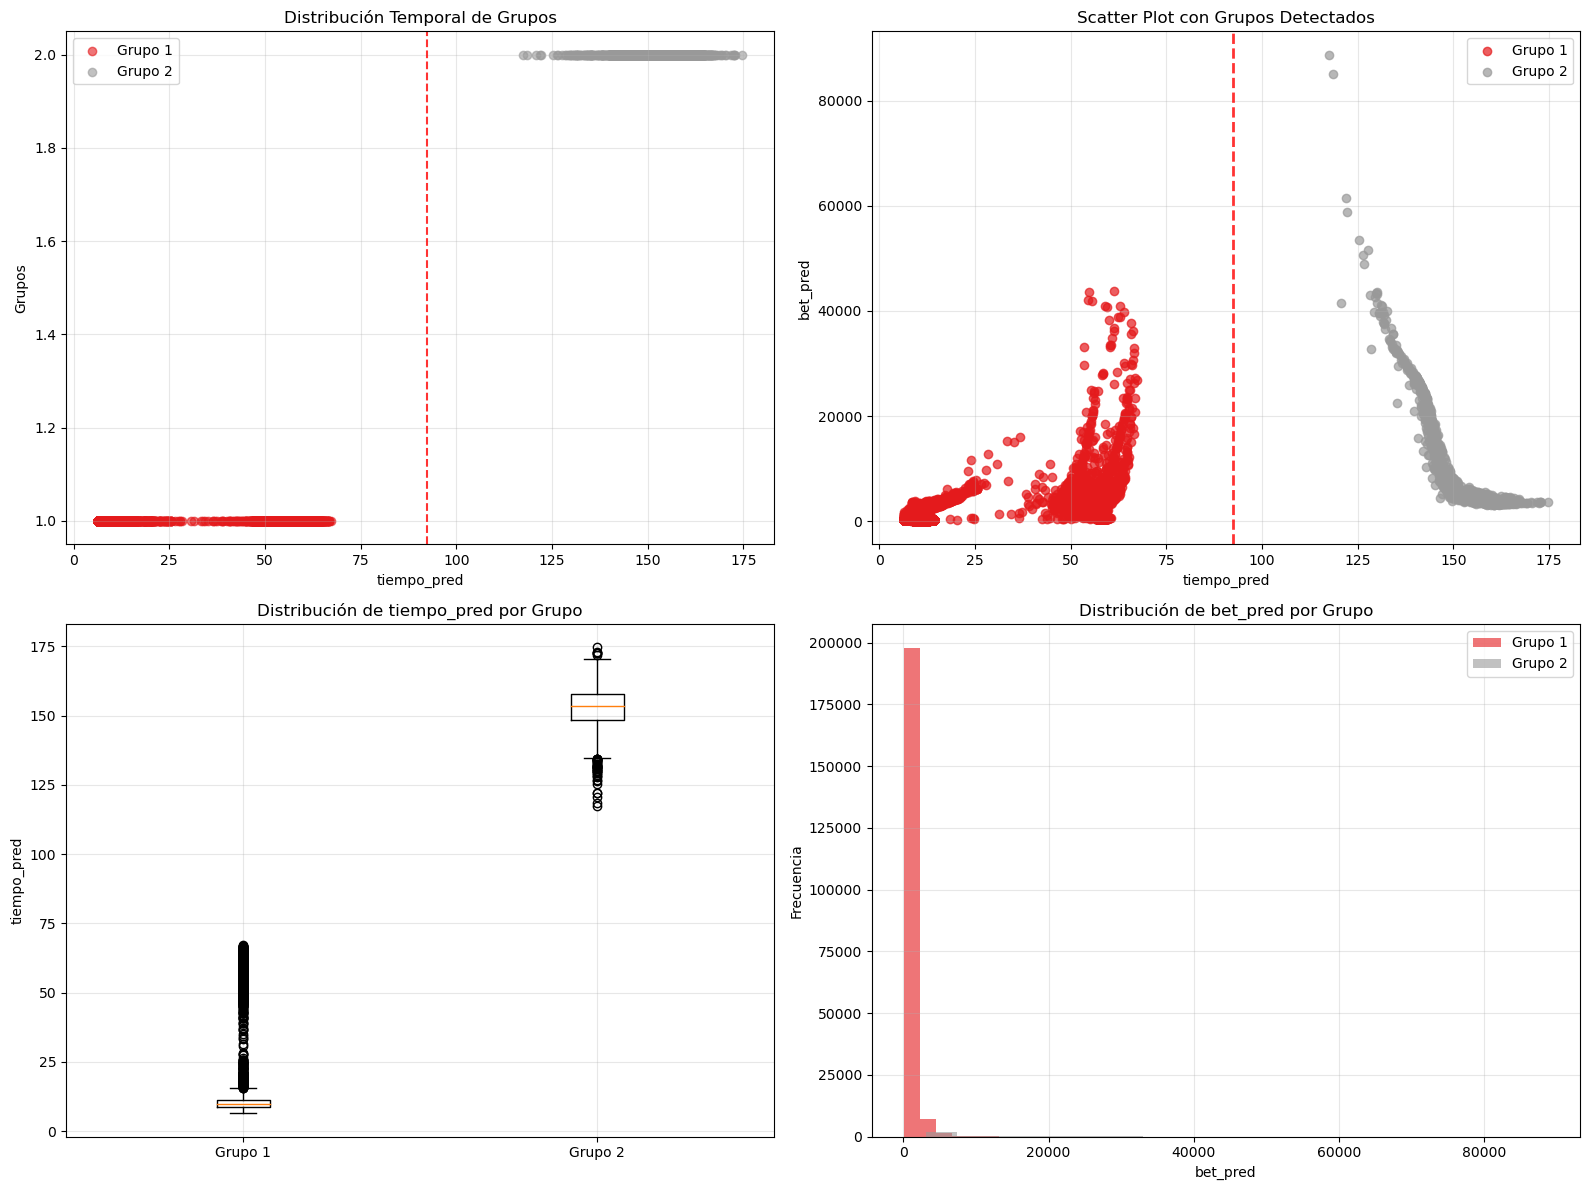

In [35]:
resultado = procesar_datos_completo(df)

🔍 ANÁLISIS COMPLETO DE LÍMITES ENTRE GRUPOS 🔍

=== ANÁLISIS DETALLADO DE LÍMITES ENTRE GRUPOS ===

=== DATOS EXTREMOS POR GRUPO ===

GRUPO 1:
  Total de datos: 206763
  Rango temporal: 6.44 - 67.25
  Primeros 5 datos (menor tiempo):
    tiempo: 6.44, bet_pred: 263.51
    tiempo: 6.44, bet_pred: 330.98
    tiempo: 6.44, bet_pred: 194.80
    tiempo: 6.44, bet_pred: 333.22
    tiempo: 6.44, bet_pred: 277.97
  Últimos 5 datos (mayor tiempo):
    tiempo: 66.66, bet_pred: 32951.42
    tiempo: 66.69, bet_pred: 20717.64
    tiempo: 66.77, bet_pred: 27321.61
    tiempo: 66.78, bet_pred: 23516.06
    tiempo: 67.25, bet_pred: 26845.89

GRUPO 2:
  Total de datos: 2316
  Rango temporal: 117.39 - 174.69
  Primeros 5 datos (menor tiempo):
    tiempo: 117.39, bet_pred: 88789.70
    tiempo: 118.50, bet_pred: 85143.86
    tiempo: 120.77, bet_pred: 41480.80
    tiempo: 121.90, bet_pred: 61535.48
    tiempo: 122.10, bet_pred: 58749.27
  Últimos 5 datos (mayor tiempo):
    tiempo: 172.43, bet_pred: 3458.13

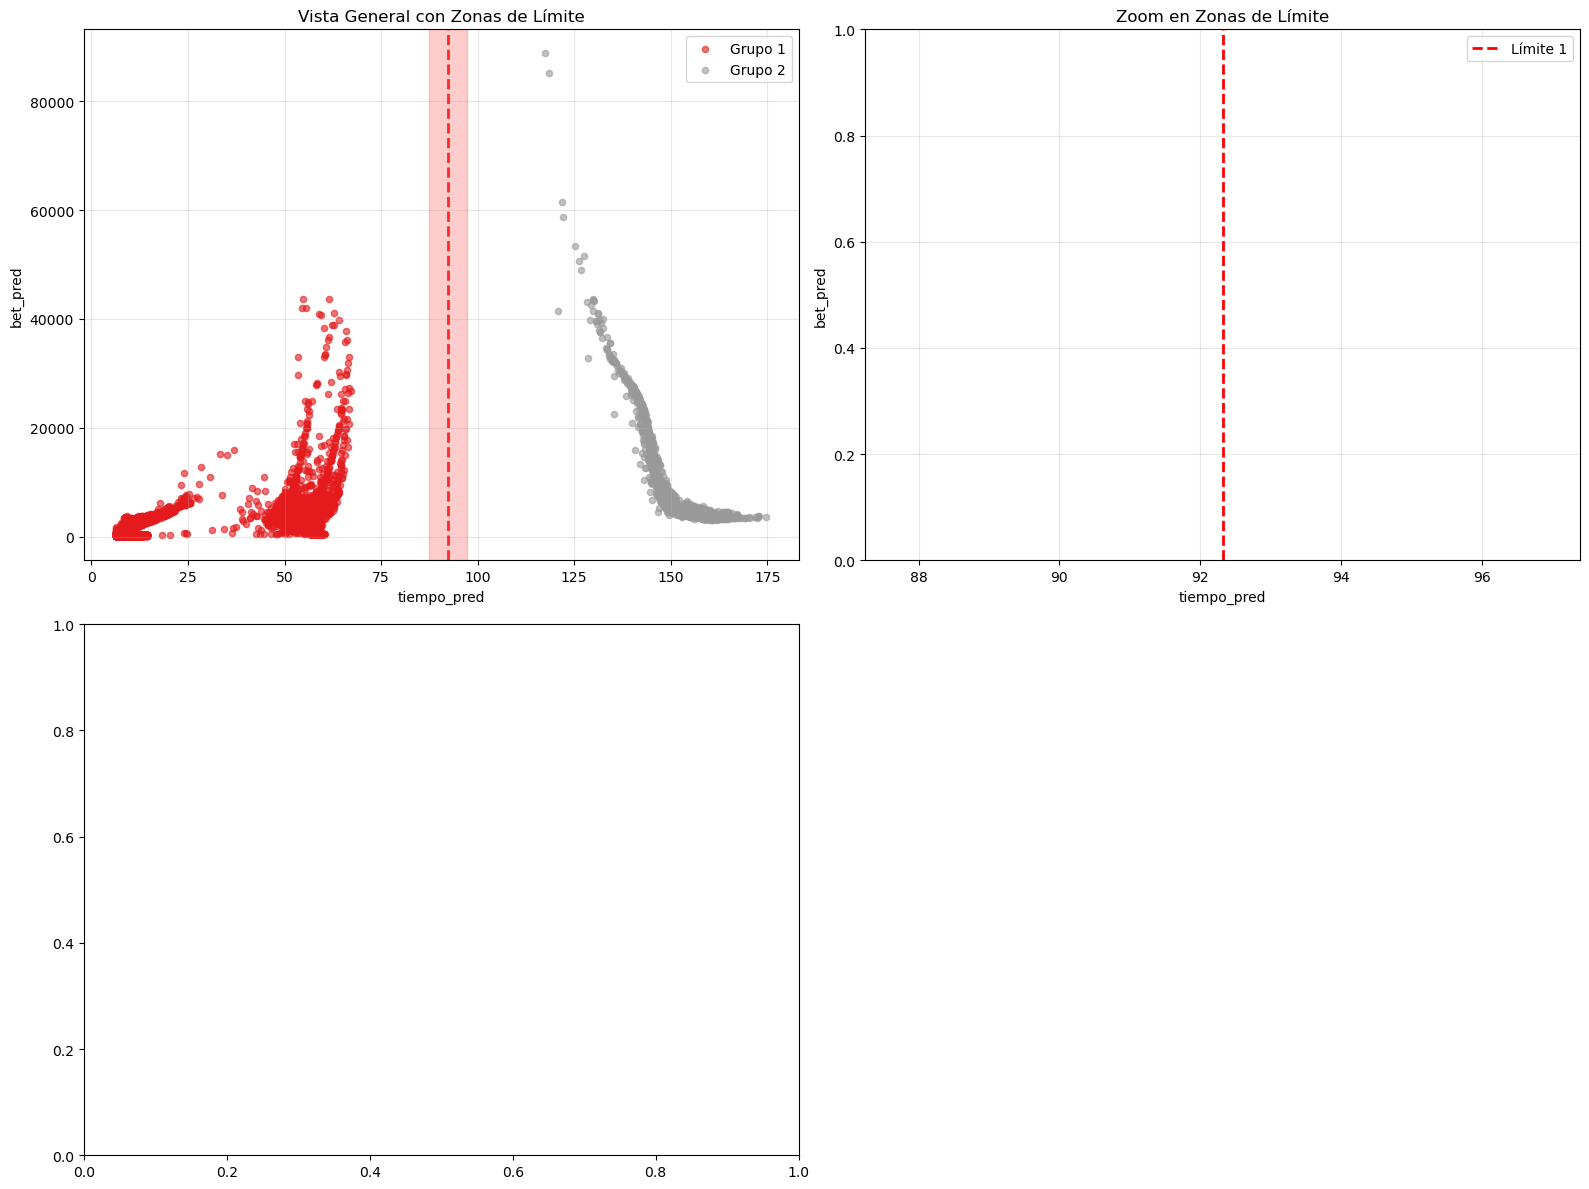

=== RESUMEN EJECUTIVO ===
Total de límites detectados: 1


In [36]:
df_con_grupos = resultado['dataframe_con_grupos']
puntos_separacion = resultado['puntos_separacion']

# Análisis detallado de límites
analisis_limites = analisis_completo_limites(df_con_grupos, puntos_separacion, tolerancia=5)



In [37]:
from sklearn.cluster import DBSCAN
X = df[['tiempo_pred', 'bet_pred']].copy()
dbscan = DBSCAN(eps=0.001, min_samples=3)
labels = dbscan.fit_predict(X)

In [38]:
df['dbscan'] = labels

/var/folders/ld/2yb_9mvs5t90r3x4r3v3btbc0000gn/T/ipykernel_2239/2159401901.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot: xlabel='tiempo_pred', ylabel='bet_pred'>

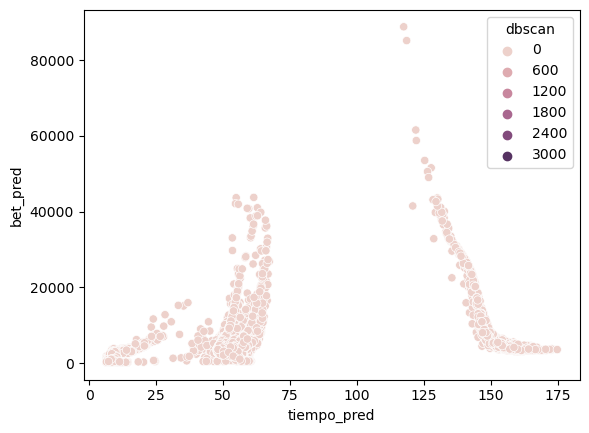

In [39]:
sns.scatterplot(df, x='tiempo_pred', y='bet_pred', hue='dbscan')

=== VERIFICACIÓN DE DATOS ===
Usando DataFrame existente
Forma de los datos: (209079, 2)
Tipo de datos: tiempo_pred    float32
bet_pred       float32
dtype: object
Valores nulos: 0
Estadísticas básicas:
         tiempo_pred       bet_pred
count  209079.000000  209079.000000
mean       15.528945     763.585815
std        19.706881    1496.016602
min         6.437281      65.881058
25%         8.535267     322.558014
50%         9.983807     444.439331
75%        11.412752     572.314240
max       174.688766   88789.695312

=== LIMPIEZA DE DATOS ===
Rango de datos: [6.437, 174.689]

=== DETERMINACIÓN DE PARÁMETROS ÓPTIMOS ===


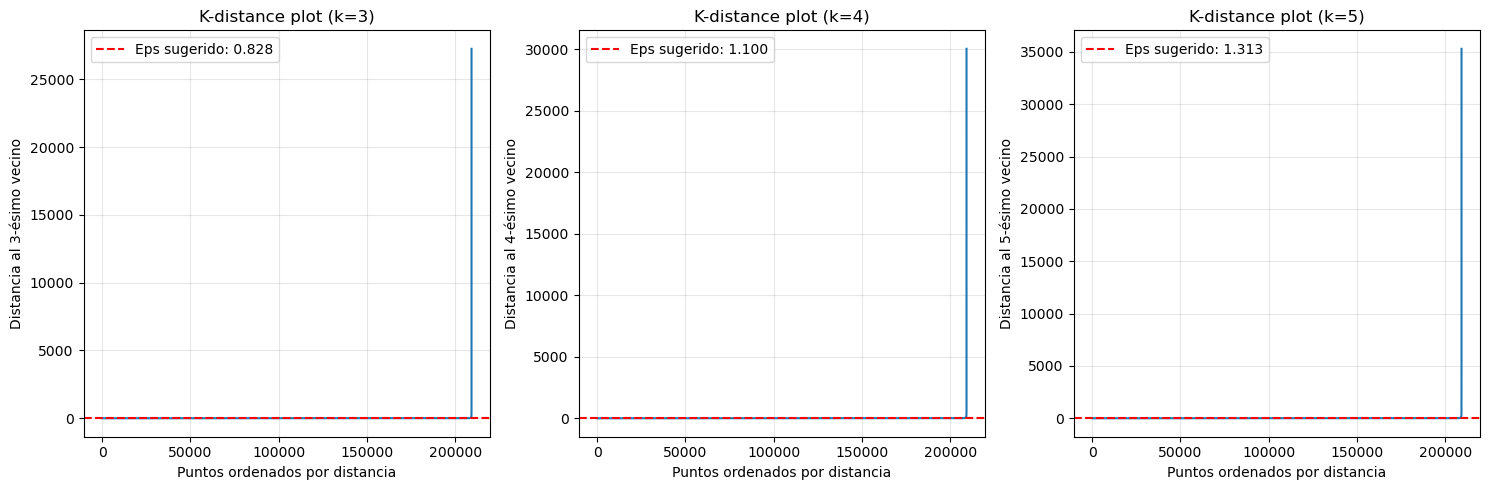

Eps sugerido basado en k-distance: 1.100

=== PROBANDO DBSCAN CON DIFERENTES PARÁMETROS ===
eps      min_samples  n_clusters   n_noise    silhouette  
-----------------------------------------------------------------


KeyboardInterrupt: 

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# PRIMER PASO: Verificar y preparar los datos
print("=== VERIFICACIÓN DE DATOS ===")

# Si 'df' no está definido, crear datos de ejemplo
try:
    # Intentar usar tu DataFrame existente
    if 'df' in locals() and 'tiempo_pred' in df.columns:
        X = df[['tiempo_pred', 'bet_pred']].copy()
        print("Usando DataFrame existente")
    else:
        print("DataFrame 'df' no encontrado. Creando datos de ejemplo...")
        raise NameError("df no definido")
except:
    # Crear datos de ejemplo si df no existe
    np.random.seed(42)
    tiempo_pred = np.random.exponential(scale=2.0, size=200)  # Distribución exponencial
    df = pd.DataFrame({'tiempo_pred': tiempo_pred})
    X = df[['tiempo_pred', 'bet_pred']].copy()
    print("Datos de ejemplo creados")

# Verificar los datos
print(f"Forma de los datos: {X.shape}")
print(f"Tipo de datos: {X.dtypes}")
print(f"Valores nulos: {X.isnull().sum().values[0]}")
print(f"Estadísticas básicas:")
print(X.describe())

# SEGUNDO PASO: Limpiar datos problemáticos
print("\n=== LIMPIEZA DE DATOS ===")

# Verificar valores infinitos o NaN
if np.isinf(X.values).any():
    print("¡ADVERTENCIA! Encontrados valores infinitos")
    X = X[~np.isinf(X.values).any(axis=1)]
    print(f"Datos después de remover infinitos: {X.shape}")

if X.isnull().any().any():
    print("¡ADVERTENCIA! Encontrados valores NaN")
    X = X.dropna()
    print(f"Datos después de remover NaN: {X.shape}")

# Verificar si hay suficientes datos
if len(X) < 5:
    print("ERROR: Muy pocos datos para clustering")
    exit()

print(f"Rango de datos: [{X.min().values[0]:.3f}, {X.max().values[0]:.3f}]")

# TERCER PASO: Determinar parámetros óptimos de DBSCAN
print("\n=== DETERMINACIÓN DE PARÁMETROS ÓPTIMOS ===")

# Método del k-nearest neighbors para encontrar eps óptimo
def find_optimal_eps(data, k=4):
    """
    Encuentra el eps óptimo usando el método del k-nearest neighbors
    """
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)
    
    # Tomar la distancia al k-ésimo vecino más cercano
    distances = distances[:, k-1]
    distances = np.sort(distances, axis=0)
    
    return distances

# Calcular distancias para diferentes valores de k
k_values = [3, 4, 5]
plt.figure(figsize=(15, 5))

for i, k in enumerate(k_values):
    plt.subplot(1, 3, i+1)
    distances = find_optimal_eps(X.values, k=k)
    plt.plot(distances)
    plt.title(f'K-distance plot (k={k})')
    plt.xlabel('Puntos ordenados por distancia')
    plt.ylabel(f'Distancia al {k}-ésimo vecino')
    plt.grid(True, alpha=0.3)
    
    # Sugerir eps (buscar el "codo" en la curva)
    # Método simple: percentil 95
    suggested_eps = np.percentile(distances, 95)
    plt.axhline(y=suggested_eps, color='red', linestyle='--', 
                label=f'Eps sugerido: {suggested_eps:.3f}')
    plt.legend()

plt.tight_layout()
plt.show()

# Calcular eps sugerido
distances = find_optimal_eps(X.values, k=4)
eps_suggested = np.percentile(distances, 95)
print(f"Eps sugerido basado en k-distance: {eps_suggested:.3f}")

# CUARTO PASO: Probar DBSCAN con diferentes parámetros
print("\n=== PROBANDO DBSCAN CON DIFERENTES PARÁMETROS ===")

# Parámetros a probar
eps_values = [eps_suggested * 0.5, eps_suggested, eps_suggested * 1.5, eps_suggested * 2.0]
min_samples_values = [2, 3, 5, 8]

results = []

print(f"{'eps':<8} {'min_samples':<12} {'n_clusters':<12} {'n_noise':<10} {'silhouette':<12}")
print("-" * 65)

for eps in eps_values:
    for min_samples in min_samples_values:
        try:
            # Aplicar DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            # Calcular métricas
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            # Calcular silhouette score si hay clusters
            if n_clusters > 1:
                from sklearn.metrics import silhouette_score
                # Para silhouette, excluir puntos de ruido
                mask = labels != -1
                if np.sum(mask) > 1:
                    sil_score = silhouette_score(X[mask], labels[mask])
                else:
                    sil_score = -1
            else:
                sil_score = -1
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': sil_score,
                'labels': labels
            })
            
            print(f"{eps:<8.3f} {min_samples:<12} {n_clusters:<12} {n_noise:<10} {sil_score:<12.3f}")
            
        except Exception as e:
            print(f"Error con eps={eps:.3f}, min_samples={min_samples}: {str(e)}")

# QUINTO PASO: Seleccionar mejores parámetros y aplicar DBSCAN
print("\n=== APLICANDO DBSCAN CON PARÁMETROS ÓPTIMOS ===")

# Seleccionar la configuración con mejor silhouette score
valid_results = [r for r in results if r['silhouette'] > 0]
if valid_results:
    best_result = max(valid_results, key=lambda x: x['silhouette'])
    print(f"Mejores parámetros encontrados:")
    print(f"  eps: {best_result['eps']:.3f}")
    print(f"  min_samples: {best_result['min_samples']}")
    print(f"  Silhouette score: {best_result['silhouette']:.3f}")
    
    best_labels = best_result['labels']
else:
    # Si no hay resultados válidos, usar parámetros conservadores
    print("No se encontraron parámetros óptimos. Usando configuración conservadora...")
    dbscan = DBSCAN(eps=eps_suggested, min_samples=3)
    best_labels = dbscan.fit_predict(X)
    best_result = {
        'eps': eps_suggested,
        'min_samples': 3,
        'n_clusters': len(set(best_labels)) - (1 if -1 in best_labels else 0),
        'n_noise': list(best_labels).count(-1)
    }

print(f"\nResultados finales:")
print(f"  Clusters encontrados: {best_result['n_clusters']}")
print(f"  Puntos de ruido: {best_result['n_noise']}")
print(f"  Total de puntos: {len(X)}")

# SEXTO PASO: Visualizar resultados
print("\n=== VISUALIZACIÓN DE RESULTADOS ===")

plt.figure(figsize=(15, 5))

# Gráfico 1: Histograma de los datos originales
plt.subplot(1, 3, 1)
plt.hist(X.values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribución de tiempo_pred')
plt.xlabel('tiempo_pred')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)

# Gráfico 2: Scatter plot de los clusters
plt.subplot(1, 3, 2)
unique_labels = set(best_labels)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

for i, label in enumerate(unique_labels):
    if label == -1:
        color = 'black'
        marker = 'x'
        alpha = 0.8
        label_name = 'Ruido'
    else:
        color = colors[i % len(colors)]
        marker = 'o'
        alpha = 0.7
        label_name = f'Cluster {label}'
    
    cluster_mask = best_labels == label
    cluster_points = X[cluster_mask]
    
    # Para datos 1D, usar índices como eje Y
    y_values = np.where(cluster_mask)[0]
    plt.scatter(cluster_points.values, y_values, 
                c=color, marker=marker, alpha=alpha, label=label_name)

plt.title('Clusters DBSCAN')
plt.xlabel('tiempo_pred')
plt.ylabel('Índice del punto')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: Box plot por cluster
plt.subplot(1, 3, 3)
cluster_data = []
cluster_labels_plot = []

for label in unique_labels:
    if label != -1:  # Excluir ruido
        cluster_points = X[best_labels == label].values.flatten()
        cluster_data.append(cluster_points)
        cluster_labels_plot.append(f'Cluster {label}')

if cluster_data:
    plt.boxplot(cluster_data, labels=cluster_labels_plot)
    plt.title('Distribución por Cluster')
    plt.xlabel('Clusters')
    plt.ylabel('tiempo_pred')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No se encontraron clusters válidos', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Sin clusters válidos')

plt.tight_layout()
plt.show()

# SÉPTIMO PASO: Análisis detallado de clusters
print("\n=== ANÁLISIS DETALLADO DE CLUSTERS ===")

for label in sorted(set(best_labels)):
    cluster_mask = best_labels == label
    cluster_points = X[cluster_mask]
    
    if label == -1:
        print(f"\nPuntos de RUIDO ({np.sum(cluster_mask)} puntos):")
    else:
        print(f"\nCLUSTER {label} ({np.sum(cluster_mask)} puntos):")
    
    print(f"  Rango: [{cluster_points.min().values[0]:.3f}, {cluster_points.max().values[0]:.3f}]")
    print(f"  Media: {cluster_points.mean().values[0]:.3f}")
    print(f"  Mediana: {cluster_points.median().values[0]:.3f}")
    print(f"  Desviación estándar: {cluster_points.std().values[0]:.3f}")

print("\n=== CÓDIGO LISTO PARA USAR ===")
print(f"""
# Tu código corregido:
X = df[['tiempo_pred']].dropna()  # Limpiar datos
dbscan = DBSCAN(eps={best_result['eps']:.3f}, min_samples={best_result['min_samples']})
labels = dbscan.fit_predict(X)
print(f"Clusters: {{len(set(labels)) - (1 if -1 in labels else 0)}}")
print(f"Ruido: {{list(labels).count(-1)}}")
""")